In [23]:
import torch
import pandas as pd
import sklearn
import scprep
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.font_manager
import sklearn.manifold
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

# some matplotlib settings
%matplotlib inline
# It's also possible to use the reduced notation by directly setting font.family:
# plt.rcParams.update({
#   "text.usetex": True,
#   "font.family": "Helvetica"
# })

# get path
dataset = 'CUB'
best_model_path = f"/home/thien/research/pseudogroups/{dataset}/splitpgl_sweep_logs/p0.5_wd0.0001_lr0.0001/part1_s0/best_model.pth"
data_path = f"/home/thien/research/pseudogroups/{dataset}/splitpgl_sweep_logs/p0.5_wd0.0001_lr0.0001/part1_s0/part1and2_data_p0.5"

device = 'cpu'

# load data splits
data = torch.load(data_path)
part1_data, part2_data = data['part1'], data['part2']
batch_size = 32

part1_loader = DataLoader(part1_data, shuffle=False, batch_size=batch_size, pin_memory=True)
part2_loader = DataLoader(part2_data, shuffle=False, batch_size=batch_size, pin_memory=True)


for p, pdat in data.items():
    print( p, 'n=',len(pdat))
    for group_idx in range(pdat.n_groups):
        print(
            f'    {pdat.group_str(group_idx)}: n = {pdat.group_counts()[group_idx]:.0f}\n'
        )
        
group_to_name = {0: 'Landbird on Land', 1: 'Landbird on Water',
                2: 'Waterbird on Land', 3: 'Waterbird on Water'}

part1 n= 2397
    waterbird_complete95 = 0, forest2water2 = 0: n = 1737

    waterbird_complete95 = 0, forest2water2 = 1: n = 104

    waterbird_complete95 = 1, forest2water2 = 0: n = 26

    waterbird_complete95 = 1, forest2water2 = 1: n = 530

part2 n= 2398
    waterbird_complete95 = 0, forest2water2 = 0: n = 1761

    waterbird_complete95 = 0, forest2water2 = 1: n = 80

    waterbird_complete95 = 1, forest2water2 = 0: n = 30

    waterbird_complete95 = 1, forest2water2 = 1: n = 527



In [24]:
# load model
model = torch.load(best_model_path)
model.to(device)
model.eval()

# make model save its features in 
activation = {}
def get_activation(name):
    def hook(model, inp, output):
#         print('inp\n\t', inp)
#         print('outp\n\t',output)
        activation[name] = inp[0].detach()
    return hook

model.fc.register_forward_hook(get_activation('fc'))


def get_feature_group(data_loader, model):
    
    feature_list = None
    group_list = None

    with torch.set_grad_enabled(False):
        for batch in tqdm(data_loader):
            batch = tuple(t.to(device) for t in batch)
            x, y, g, idx = batch
            outputs = model(x)
            features = activation['fc'].detach().numpy()

            # now save the group and features
            if feature_list is None:
                feature_list = features
                group_list = g.detach().numpy()
            else:
                feature_list = np.concatenate([feature_list, features])
                group_list = np.concatenate([group_list, g.detach().numpy()])

    group_label = []

    for g in group_list:
        group_label.append(group_to_name[g])
    
    return feature_list, group_list, group_label


In [3]:
# part1_feature_list, part1_group_list, part1_group_label = get_feature_group(part1_loader, model)
# part2_feature_list, part2_group_list, part2_group_label = get_feature_group(part2_loader, model)

100%|██████████| 75/75 [02:26<00:00,  1.90s/it]


# TSNE

In [4]:
run_pca = False
subsample = False

if run_pca:
    # reduce dimension to speed up TSNE
    part1_prep = scprep.reduce.pca(part1_feature_list, n_components=100, method='dense')
    part2_prep = scprep.reduce.pca(part2_feature_list, n_components=100, method='dense')
else:
    part1_prep = part1_feature_list
    part2_prep = part2_feature_list
    
# if subsample:
#     data_pca_subsample, metadata_subsample = scprep.select.subsample(data_pca, metadata, n=3000)
    

In [98]:
# perplexity set the size of the cluster
perplexity = 40
seed = 5
tsne_op = sklearn.manifold.TSNE(n_components=2, perplexity=perplexity, random_state=seed)

part1_tsne = tsne_op.fit_transform(part1_prep)
part2_tsne = tsne_op.fit_transform(part2_prep)

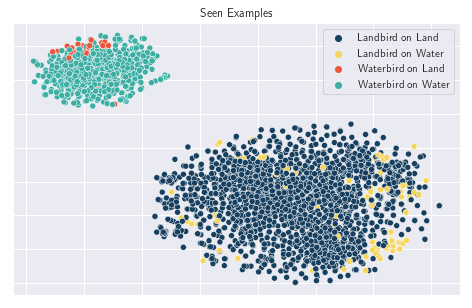

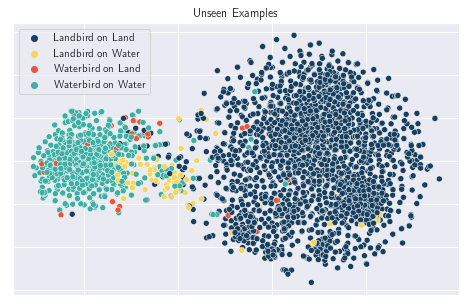

In [101]:
group_label_str = 'Groups'
group_list_str = 'group list'
dim1_str = 'Dimension 1'
dim2_str = 'Dimension 2'


group_names = [group_to_name[g] for g in range(4)]

color_palette = ['#173f5f', '#f6d55c', '#ed553b', '#3caea3']
# color_palette = 'Dark2_r'

def data_to_df(data, label, group_list):
    df = pd.DataFrame()
    df[group_label_str] = label
    df[dim1_str] = data[:,0]
    df[dim2_str] = data[:,1]
    df[group_list_str] = group_list 
    return df

def scatter_data(data, group_label, group_list, save_path='/home/thien/research/noname', title=''):
    plt.figure(figsize=(8,5))
    df = data_to_df(data, group_label, group_list)
    ax = sns.scatterplot(data=df, x=dim1_str, y=dim2_str, hue=group_list_str, palette=color_palette)
    handles, labels  =  ax.get_legend_handles_labels()
    ax.legend(handles, group_names, title='')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(title)
    plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    plt.savefig(save_path, format='eps', bbox_inches='tight')
    plt.show()
    

    
scatter_data(part1_tsne, part1_group_label, part1_group_list, 
             f'/home/thien/research/tsne_plot_cub_seen_data_{perplexity}_s{seed}.eps', title='Seen Examples')
scatter_data(part2_tsne, part2_group_label, part2_group_list, 
             f'/home/thien/research/tsne_plot_cub_unseen_data_{perplexity}_s{seed}.eps', title='Unseen Examples')

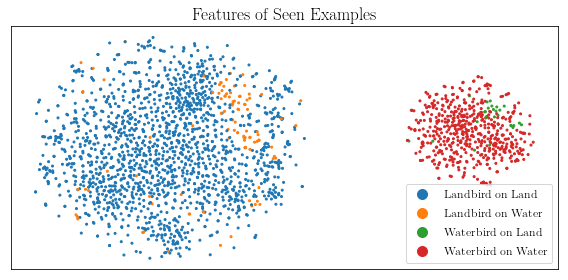

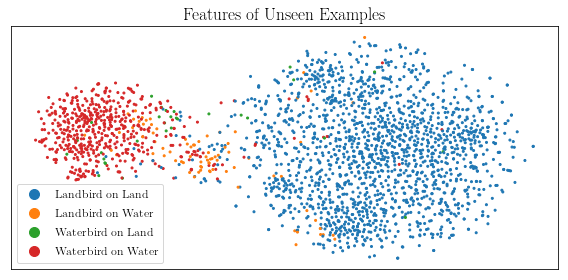

In [19]:
fig_size = (8,4)

part1_tsne_plot = scprep.plot.scatter2d(part1_tsne, c=part1_group_label,
                      figsize=fig_size, 
                      title='Features of Seen Examples',
                      ticks=False,)

part2_tsne_plot = scprep.plot.scatter2d(part2_tsne, c=part2_group_label,
                      figsize=fig_size, 
                      title='Features of Unseen Examples',
                      ticks=False,)

In [20]:
part1_tsne_plot.figure.savefig('/home/thien/research/tsne_plot_cub_seen_data_30.eps', format='eps')
part2_tsne_plot.figure.savefig('/home/thien/research/tsne_plot_cub_unseen_data_30.eps', format='eps')

# PCA

In [25]:
part1_pca = scprep.reduce.pca(part1_feature_list, n_components=2, method='dense')
part2_pca = scprep.reduce.pca(part2_feature_list, n_components=2, method='dense')

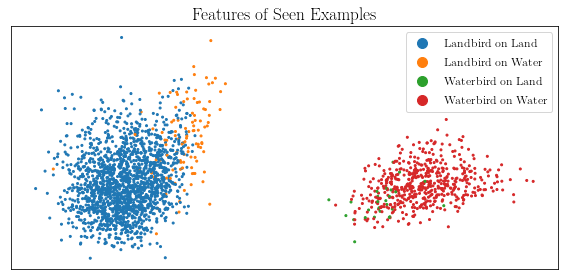

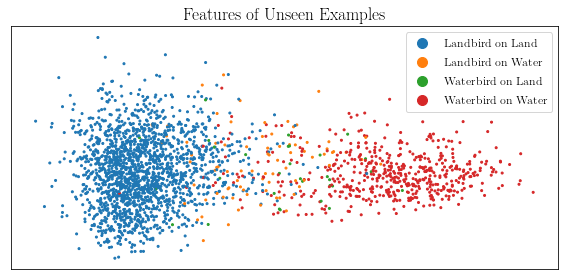

In [26]:
fig_size = (8,4)

part1_pca_plot = scprep.plot.scatter2d(part1_pca, c=part1_group_label,
                      figsize=fig_size, 
                      title='Features of Seen Examples',
                      ticks=False,)

part2_pca_plot = scprep.plot.scatter2d(part2_pca, c=part2_group_label,
                      figsize=fig_size, 
                      title='Features of Unseen Examples',
                      ticks=False,)

In [47]:
part1_pca_plot.figure.savefig('/home/thien/research/pca_plot_cub_seen_data.eps', format='eps')
part2_pca_plot.figure.savefig('/home/thien/research/pca_plot_cub_unseen_data.eps', format='eps')

# UMAP

In [69]:
import umap

nn = 9

umap_op = umap.UMAP(n_neighbors=nn, min_dist=0.15)

part1_umap = umap_op.fit_transform(part1_feature_list)
part2_umap = umap_op.fit_transform(part2_feature_list)


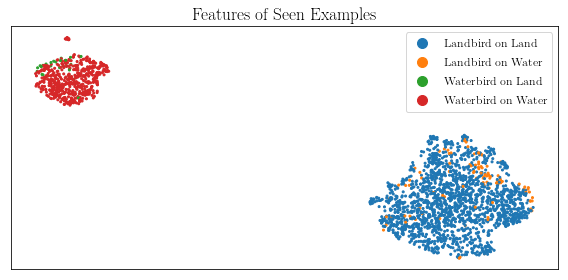

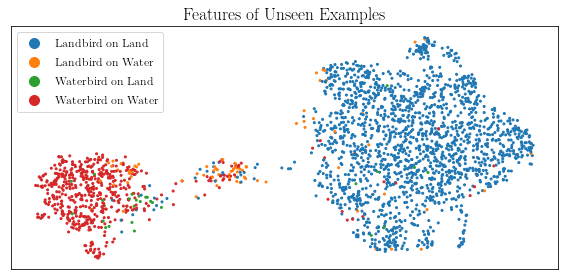

In [72]:
fig_size = (8,4)

part1_umap_plot = scprep.plot.scatter2d(part1_umap, c=part1_group_label,
                      figsize=fig_size, 
                      title='Features of Seen Examples',
                      ticks=False,)

part2_umap_plot = scprep.plot.scatter2d(part2_umap, c=part2_group_label,
                      figsize=fig_size, 
                      title='Features of Unseen Examples',
                      ticks=False,)

part1_umap_plot.figure.savefig(f'/home/thien/research/umap_plot_cub_seen_data_{nn}.eps', format='eps')
part2_umap_plot.figure.savefig(f'/home/thien/research/umap_plot_cub_unseen_data_{nn}.eps', format='eps')